<a href="https://colab.research.google.com/github/Kroomer/Master-Thesis/blob/main/Master_thesis_1_baseline_downsampling_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect to drive**  


Click link and enter authorization code

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Master thesis"

 create_extracted_dataset.R   Lexique-query.csv
 emotion_dict.csv	     'Lexique-query final.csv'
 final_dataset.csv	     'NN-SVG adapted from LeNail (2019).png'
 halflife-regression-master  'unique words.txt'
 learning_traces.13m.csv


# **Connect to GPU**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Found GPU at: /device:GPU:0
Thu Jun 24 11:31:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    72W / 149W |    122MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

# **Import libraries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

import pydot 
import graphviz
from tensorflow.keras.utils import plot_model

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, plot_roc_curve, precision_recall_fscore_support, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import os
import tempfile

# # Fix for random errors
# import six
# import sys
# sys.modules['sklearn.externals.six'] = six
# import sklearn.neighbors._base
# sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import imblearn
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import statistics
from scipy import interp
from scipy.stats import truncnorm

# fix random seed for reproducibility
np.random.seed(14)
tf.random.set_seed(14)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# **Import data**  
Final dataset created using "create_extracted_dataset.R"

Combining data from:
1. Duolingo spaced repetition (1.21 GB)
> B. Settles and B. Meeder. 2016. A Trainable Spaced Repetition Model for Language Learning.
In Proceedings of the Association for Computational Linguistics (ACL), pages 1848-1858.<br/>
> https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/N8XJME
2. SUBTLEX-US data 
>Manually created on http://www.lexique.org/shiny/openlexicon/
3. "Emotion dictionary", created by Geoff Hollis and Chris Westbury based on Warriner, Kuperman and Brysbaert (*2007*)
>Link: http://crr.ugent.be/programs-data,<br/>
>Direct link: https://sites.ualberta.ca/~hollis/files/emotion_dict.csv



In [ ]:
final_dataset = pd.read_csv("drive/My Drive/Colab Notebooks/Master thesis/final_dataset.csv", sep=',')
final_dataset.head()

,p_recall,timestamp,delta,history_seen,history_correct,history_incorrect,dummy_noun,dummy_verb,words,FREQcount,CDcount,Valence,Arousal,Concreteness
0,1,1362082519,3888560,5,5,0,0,1,thank,56877,7790,0.751554,0.377968,0.557784
1,1,1362082532,287,40,37,3,0,0,i,2038529,8372,0.544628,0.371790,0.533944
2,1,1362082532,287,87,80,7,0,0,the,1501908,8388,0.645179,0.330776,0.461627
3,1,1362082532,287,79,70,9,1,0,apple,1207,689,0.646746,0.339613,0.974410
4,1,1362082532,287,64,56,8,1,0,man,94133,8054,0.505728,0.451745,0.916435


In [ ]:
# Don't want the "words" column.
final_dataset.pop('words')
final_dataset.describe()

,p_recall,timestamp,delta,history_seen,history_correct,history_incorrect,dummy_noun,dummy_verb,FREQcount,CDcount,Valence,Arousal,Concreteness
count,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06
mean,8.361450e-01,1.362589e+09,6.862933e+05,3.972093e+01,3.424126e+01,5.479667e+00,4.666492e-01,2.197202e-01,1.600285e+05,4.338620e+03,6.057379e-01,3.775665e-01,6.499140e-01
std,3.701440e-01,2.942436e+05,2.084959e+06,2.311720e+02,1.985168e+02,4.987316e+01,4.988866e-01,4.140571e-01,3.646153e+05,3.257039e+03,6.758736e-02,4.693279e-02,2.153472e-01
min,0.000000e+00,1.362083e+09,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,1.400000e+01,1.331056e-01,1.841600e-01,9.250205e-02
25%,1.000000e+00,1.362346e+09,4.690000e+02,4.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.724000e+03,1.022000e+03,5.621335e-01,3.460062e-01,4.692620e-01
50%,1.000000e+00,1.362595e+09,4.183800e+04,8.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.033600e+04,3.827000e+03,6.057379e-01,3.760237e-01,6.539603e-01
75%,1.000000e+00,1.362845e+09,3.846388e+05,2.000000e+01,1.800000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.083640e+05,8.254000e+03,6.467458e-01,4.038101e-01,8.294996e-01
max,1.000000e+00,1.363105e+09,3.724681e+07,1.351800e+04,1.288800e+04,2.457000e+03,1.000000e+00,1.000000e+00,2.134713e+06,8.388000e+03,8.936641e-01,6.609906e-01,1.074385e+00


# **Clean data**

In [ ]:
cleaned_df = final_dataset.copy()

# Columns covering a huge range. Convert to log-space.
cleaned_df['log timestamp'] = np.log(cleaned_df.pop('timestamp'))
cleaned_df['log delta'] = np.log(cleaned_df.pop('delta'))
cleaned_df['log history_seen'] = np.log(cleaned_df.pop('history_seen'))
cleaned_df['log history_correct'] = np.log(cleaned_df.pop('history_correct'))
cleaned_df['log FREQcount'] = np.log(cleaned_df.pop('FREQcount'))
cleaned_df['log CDcount'] = np.log(cleaned_df.pop('CDcount'))
cleaned_df['log Valence'] = np.log(cleaned_df.pop('Valence'))
cleaned_df['log Arousal'] = np.log(cleaned_df.pop('Arousal'))
cleaned_df['log Concreteness'] = np.log(cleaned_df.pop('Concreteness'))
cleaned_df.describe()

,p_recall,history_incorrect,dummy_noun,dummy_verb,log timestamp,log delta,log history_seen,log history_correct,log FREQcount,log CDcount,log Valence,log Arousal,log Concreteness
count,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06
mean,8.361450e-01,5.479667e+00,4.666492e-01,2.197202e-01,2.103265e+01,9.752850e+00,2.275656e+00,2.160277e+00,9.518371e+00,7.862031e+00,-5.078608e-01,-9.817592e-01,-4.956570e-01
std,3.701440e-01,4.987316e+01,4.988866e-01,4.140571e-01,2.159446e-04,3.559627e+00,1.315525e+00,1.317163e+00,2.492906e+00,1.213273e+00,1.166200e-01,1.248932e-01,3.782716e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.103228e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.944439e+00,2.639057e+00,-2.016613e+00,-1.691950e+00,-2.380524e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.103247e+01,6.150603e+00,1.386294e+00,1.098612e+00,7.452402e+00,6.929517e+00,-5.760160e-01,-1.061299e+00,-7.565941e-01
50%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.103266e+01,1.064156e+01,2.079442e+00,1.945910e+00,9.243388e+00,8.249836e+00,-5.013079e-01,-9.781031e-01,-4.247086e-01
75%,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,2.103284e+01,1.286006e+01,2.995732e+00,2.890372e+00,1.159325e+01,9.018453e+00,-4.358019e-01,-9.068106e-01,-1.869326e-01
max,1.000000e+00,2.457000e+03,1.000000e+00,1.000000e+00,2.103303e+01,1.743308e+01,9.511777e+00,9.464052e+00,1.457384e+01,9.034557e+00,-1.124253e-01,-4.140156e-01,7.174847e-02


**Imbalanced data**  
On target variable "p_recall"

Examples:
	Total:		3628934
	Negative:	594619	(16.39% of total)
	Positive:	3034315	(83.61% of total)



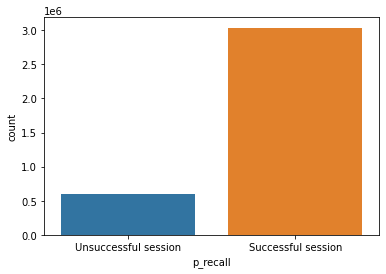

In [ ]:
# Describe target
neg_clean, pos_clean = np.bincount(cleaned_df['p_recall'])
total_clean = neg_clean + pos_clean
print('Examples:\n\tTotal:\t\t{}\n\tNegative:\t{}\t({:.2f}% of total)\n\tPositive:\t{}\t({:.2f}% of total)\n'.format(
    total_clean, neg_clean, 100 * neg_clean / total_clean, pos_clean, 100 * pos_clean / total_clean))
# visualize target
g = sns.countplot(x='p_recall',data=cleaned_df)
g.set_xticklabels(['Unsuccessful session','Successful session'])
plt.savefig('/content/drive/My Drive/Colab Notebooks/Results/Imbalanced_data_plot.png')
plt.show()

# **Create features and labels**

In [ ]:
# Create labels train and test
# .pop already deletes p_recall from data
df = cleaned_df.copy()

y = np.array(df.pop('p_recall'))
x = np.array(df.copy())

# **Baseline Random Forest**  
3 repeated stratified 5 fold

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Runtime complete 3 repeated 5 fold in seconds:
# 1400 sec

# RandomForestClassifier
# Instantiate model with 16 decision trees baseline combined model from Coerver (2020)
rf = RandomForestClassifier(
    n_estimators= 16, max_depth= 16, criterion= 'gini', min_samples_split=64, 
    min_samples_leaf=32, max_features=8)

# Define pipeline
# Sample -> scale -> model
steps = [('under', RandomUnderSampler(random_state=14, replacement=True)), ('scaler', StandardScaler()), ('model', rf)]
pipeline = Pipeline(steps=steps)

scoring = {
           'accuracy': make_scorer(accuracy_score),
           'f1': make_scorer(f1_score),
           'specificity' : make_scorer(recall_score, pos_label=0), # Recall on 0 class = specificity
           'ROC_AUC' : make_scorer(roc_auc_score)
           } 

# k-fold: 5, repeat: 3, random_state to reproduce because comp and time restriction (multiple models)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=14)
scores = cross_validate(pipeline, x, y, scoring=scoring, cv=cv)

In [ ]:
accuracy_RFC = scores['test_accuracy']
score = statistics.mean(accuracy_RFC)
min = np.min(accuracy_RFC)
max = np.max(accuracy_RFC)
median = statistics.median(accuracy_RFC)
std = statistics.stdev(accuracy_RFC)
print('Mean accuracy:\t', score, '\nMedian:\t\t', median, '\nMin:\t\t', min, '\nMax:\t\t', max, '\nStd.:\t\t', std)

F1_RFC = scores['test_f1']
specificity_RFC = scores['test_specificity']
ROC_AUC_RFC = scores['test_ROC_AUC']
print('\nF1:\t\t', statistics.mean(F1_RFC), '\nSpecificity:\t', statistics.mean(specificity_RFC), '\nROC AUC:\t', statistics.mean(ROC_AUC_RFC))

Mean accuracy:	 0.6098786404557921 
Median:		 0.6097877200886761 
Min:		 0.6067151933005138 
Max:		 0.6126453077831375 
Std.:		 0.001669922530101229

F1:		 0.7229591991077527 
Specificity:	 0.6154669354740722 
ROC AUC:	 0.6121252332590732


# **MLP Plots**  
Visualisation of neural network

In [ ]:
# Reset keras session
K.clear_session()

def make_model():
  model = keras.Sequential([
      # bias = false because batchnorm
      keras.layers.Dense(64, activation='relu', input_shape=(12,), use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(64, activation='relu', use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(64, activation='relu', use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(1, activation='sigmoid'),
  ])
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=.001),
      loss=keras.losses.BinaryCrossentropy(),
      )

  return model

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4096      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4

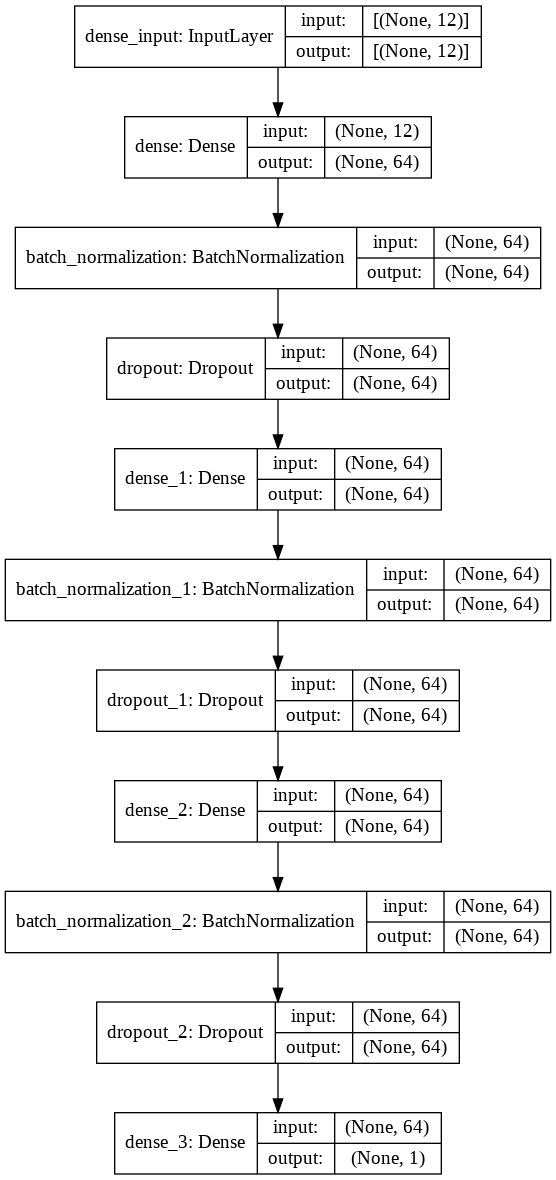

In [ ]:
# Nice visualisation
plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/Results/MLP_plot.png', show_shapes=True, show_layer_names=True)

# **MLP Model**  
3 repeated stratified 5 fold  
Sampler and scaler + reshaping data done manually

Confusion matrix printing in output (to check F1 and specificity)


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  print('\np_recall 0 correctly predicted (True Negatives):\t', cm[0][0])
  print('p_recall 1 incorrectly predicted (False Positives):\t', cm[0][1])
  print('p_recall 0 incorrectly predicted (False Negatives):\t', cm[1][0])
  print('p_recall 1 correctly predicted (True Positives):\t', cm[1][1])
  print('Total incorrectly predicted p_recall:\t\t\t', cm[1][0]+cm[0][1])

In [ ]:
# Reset keras session
K.clear_session()

# fix random seed for reproducibility
np.random.seed(14)
tf.random.set_seed(14)

rus = RandomUnderSampler(random_state=14, replacement=True)
scaler = StandardScaler()
a = 0
b = 0

METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'),
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.AUC(name='ROC_AUC'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve as a little extra
    ]

# Max 100 epochs
# Highest batchsize possible (high number of lines)
EPOCHS = 100
BATCH_SIZE = 16384

# Use early stopping, min validation loss, patience: 10 epoch
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=20,
    mode='min',
    restore_best_weights=True)

# k-fold: 5, repeat: 3, random_state to reproduce because comp and time restriction (multiple models)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=14)

Train feats (train + val) dataset: (2903147, 12) 	Test feats: (725787, 12)
Train labels (train + val) dataset: (2903147,) 		Test labels: (725787,)

Train feats sampled dataset: (713542, 12) 	Val feats: (725787, 12) 	Test feats: (725787, 12)
Train labels sampled dataset: (713542,) 	Val labels: (725787,) 		Test labels: (725787,)

Train set:
    Total:	713542
    Negative:	356771	(50.00%)
    Positive:	356771	(50.00%)

Val set:
    Total:	725787
    Negative:	118924	(16.39%)
    Positive:	606863	(83.61%)

Test set:
    Total:	725787
    Negative:	118924	(16.39%)
    Positive:	606863	(83.61%)

Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping

loss :  0.655386745929718
tp :  375078.0
fp :  48812.0
tn :  70112.0
fn :  231785.0
accuracy :  0.6133893132209778
ROC_AUC :  0.6472757458686829
prc :  0.8957857489585876
f1: 0.7515194834935743
specificity: 0.5895529918262171 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 70112
p_recall 1 incorrectly predicted (False Positives):	 48812
p_recall 0 incorrectly predicted (False Negatives):	 231785
p_recall 1 correctly predicted (True Positives):	 375078
Total incorrectly predicted p_recall:			 280597

Run: 1 completed

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping

loss :  0.6582545638084412
tp :  373135.0
fp :  49453.0
tn :  69471.0
fn :  233728.0
accuracy :  0.6098290681838989
ROC_AUC :  0.6414278149604797
prc :  0.8935950398445129
f1: 0.7467989314593031
specificity: 0.584162994853365 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 69471
p_recall 1 incorrectly predicted (False Positives):	 49453
p_recall 0 incorrectly predicted (False Negatives):	 233728
p_recall 1 correctly predicted (True Positives):	 373135
Total incorrectly predicted p_recall:			 283181

Run: 2 completed

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping

loss :  0.6625083088874817
tp :  405823.0
fp :  60868.0
tn :  58056.0
fn :  201040.0
accuracy :  0.6391392946243286
ROC_AUC :  0.6154896020889282
prc :  0.8839078545570374
f1: 0.7256729578580922
specificity: 0.48817732333213804 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 58056
p_recall 1 incorrectly predicted (False Positives):	 60868
p_recall 0 incorrectly predicted (False Negatives):	 201040
p_recall 1 correctly predicted (True Positives):	 405823
Total incorrectly predicted p_recall:			 261908

Run: 3 completed

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping

loss :  0.6590266227722168
tp :  372913.0
fp :  49135.0
tn :  69789.0
fn :  233950.0
accuracy :  0.6099613308906555
ROC_AUC :  0.6438013911247253
prc :  0.894392728805542
f1: 0.7486848058461582
specificity: 0.5868369715107238 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 69789
p_recall 1 incorrectly predicted (False Positives):	 49135
p_recall 0 incorrectly predicted (False Negatives):	 233950
p_recall 1 correctly predicted (True Positives):	 372913
Total incorrectly predicted p_recall:			 283085

Run: 4 completed

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping

loss :  0.645266592502594
tp :  473598.0
fp :  76348.0
tn :  42575.0
fn :  133265.0
accuracy :  0.711191713809967
ROC_AUC :  0.610332190990448
prc :  0.8806600570678711
f1: 0.7209899083619957
specificity: 0.35800475938182014 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 42575
p_recall 1 incorrectly predicted (False Positives):	 76348
p_recall 0 incorrectly predicted (False Negatives):	 133265
p_recall 1 correctly predicted (True Positives):	 473598
Total incorrectly predicted p_recall:			 209613

Run: 5 completed

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping

loss :  0.6482992172241211
tp :  461680.0
fp :  74855.0
tn :  44069.0
fn :  145183.0
accuracy :  0.6968284249305725
ROC_AUC :  0.6030733585357666
prc :  0.8787739276885986
f1: 0.7152763296076766
specificity: 0.3705643940664874 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 44069
p_recall 1 incorrectly predicted (False Positives):	 74855
p_recall 0 incorrectly predicted (False Negatives):	 145183
p_recall 1 correctly predicted (True Positives):	 461680
Total incorrectly predicted p_recall:			 220038

Run: 6 completed

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping

loss :  0.6607977151870728
tp :  373094.0
fp :  52326.0
tn :  66598.0
fn :  233769.0
accuracy :  0.6058140993118286
ROC_AUC :  0.6253196597099304
prc :  0.8871490359306335
f1: 0.7335711937167558
specificity: 0.5600047088892401 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 66598
p_recall 1 incorrectly predicted (False Positives):	 52326
p_recall 0 incorrectly predicted (False Negatives):	 233769
p_recall 1 correctly predicted (True Positives):	 373094
Total incorrectly predicted p_recall:			 286095

Run: 7 completed

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping

loss :  0.6333004832267761
tp :  527381.0
fp :  91833.0
tn :  27091.0
fn :  79482.0
accuracy :  0.7639596462249756
ROC_AUC :  0.6004051566123962
prc :  0.8771288394927979
f1: 0.71285355143521
specificity: 0.22780094850473595 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 27091
p_recall 1 incorrectly predicted (False Positives):	 91833
p_recall 0 incorrectly predicted (False Negatives):	 79482
p_recall 1 correctly predicted (True Positives):	 527381
Total incorrectly predicted p_recall:			 171315

Run: 8 completed

Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping

loss :  0.6509872078895569
tp :  378731.0
fp :  48701.0
tn :  70223.0
fn :  228132.0
accuracy :  0.618575394153595
ROC_AUC :  0.6523540019989014
prc :  0.8984683752059937
f1: 0.7558821033927372
specificity: 0.5904863610368046 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 70223
p_recall 1 incorrectly predicted (False Positives):	 48701
p_recall 0 incorrectly predicted (False Negatives):	 228132
p_recall 1 correctly predicted (True Positives):	 378731
Total incorrectly predicted p_recall:			 276833

Run: 9 completed

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping

loss :  0.6236538887023926
tp :  583429.0
fp :  109158.0
tn :  9765.0
fn :  23434.0
accuracy :  0.8173125386238098
ROC_AUC :  0.5842208862304688
prc :  0.8718590140342712
f1: 0.6996295268611491
specificity: 0.0821119547942096 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 9765
p_recall 1 incorrectly predicted (False Positives):	 109158
p_recall 0 incorrectly predicted (False Negatives):	 23434
p_recall 1 correctly predicted (True Positives):	 583429
Total incorrectly predicted p_recall:			 132592

Run: 10 completed

Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping

loss :  0.6484794020652771
tp :  378718.0
fp :  48218.0
tn :  70706.0
fn :  228145.0
accuracy :  0.6192229986190796
ROC_AUC :  0.6556800007820129
prc :  0.899629533290863
f1: 0.7585230851726212
specificity: 0.5945477784126042 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 70706
p_recall 1 incorrectly predicted (False Positives):	 48218
p_recall 0 incorrectly predicted (False Negatives):	 228145
p_recall 1 correctly predicted (True Positives):	 378718
Total incorrectly predicted p_recall:			 276363

Run: 11 completed

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping

loss :  0.655132532119751
tp :  424326.0
fp :  66354.0
tn :  52570.0
fn :  182537.0
accuracy :  0.6570743322372437
ROC_AUC :  0.6055904030799866
prc :  0.8795465230941772
f1: 0.7173007741721716
specificity: 0.442047021626886 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 52570
p_recall 1 incorrectly predicted (False Positives):	 66354
p_recall 0 incorrectly predicted (False Negatives):	 182537
p_recall 1 correctly predicted (True Positives):	 424326
Total incorrectly predicted p_recall:			 248891

Run: 12 completed

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping

loss :  0.6624144911766052
tp :  372382.0
fp :  49115.0
tn :  69809.0
fn :  234481.0
accuracy :  0.6092572808265686
ROC_AUC :  0.643210768699646
prc :  0.8941740989685059
f1: 0.7482087558481053
specificity: 0.587005146143262 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 69809
p_recall 1 incorrectly predicted (False Positives):	 49115
p_recall 0 incorrectly predicted (False Negatives):	 234481
p_recall 1 correctly predicted (True Positives):	 372382
Total incorrectly predicted p_recall:			 283596

Run: 13 completed

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping

loss :  0.6552818417549133
tp :  377834.0
fp :  49925.0
tn :  68999.0
fn :  229029.0
accuracy :  0.6156530976295471
ROC_AUC :  0.6440442204475403
prc :  0.8945838212966919
f1: 0.7489159487290612
specificity: 0.5801940735254615 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 68999
p_recall 1 incorrectly predicted (False Positives):	 49925
p_recall 0 incorrectly predicted (False Negatives):	 229029
p_recall 1 correctly predicted (True Positives):	 377834
Total incorrectly predicted p_recall:			 278954

Run: 14 completed


loss :  0.6537872552871704
tp :  369660.0
fp :  45845.0
tn :  73078.0
fn :  237203.0
accuracy :  0.6100117564201355
ROC_AUC :  0.6579264998435974
prc :  0.9004130363464355
f1: 0.7603036227461982
specificity: 0.614498456984255 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 73078
p_recall 1 incorrectly predicted (False Positives):	 45845
p_recall 0 incorrectly predicted (False Negatives):	 237203
p_recall 1 correctly predicted (True Positives):	 369660
Total incorrectly predicted p_recall:			 283048

Run: 15 completed



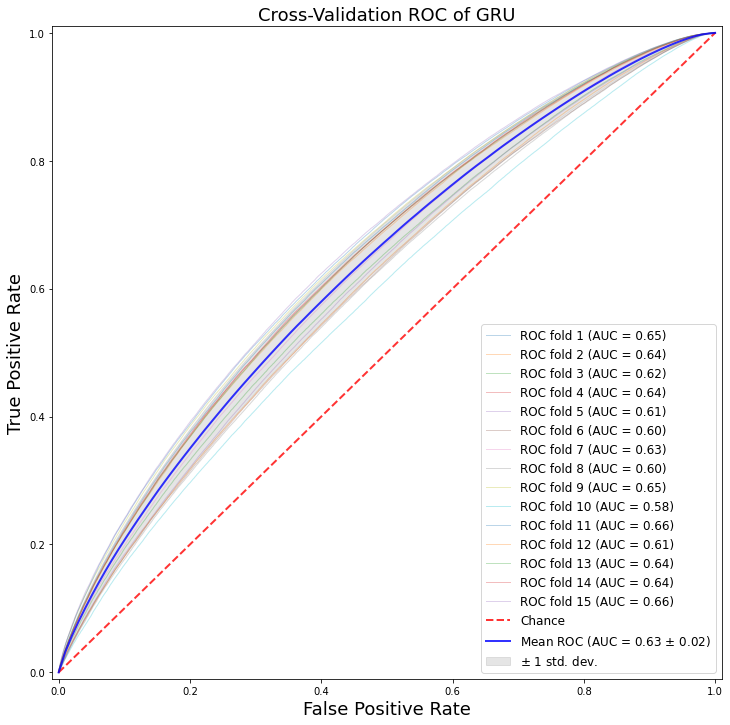

In [ ]:
# Runtime complete 3 repeated 5 fold in seconds:
# 1860 sec

# Manual loop to reshape k fold train data for GRU prediction model
plt.rcParams["figure.figsize"] = (12,12)

accuracy_MLP = []
specificity_MLP = []
ROC_AUC_MLP = []
F1_MLP = []

# ROC AUC plot
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

# Loop through the indices the split() method returns
for index, (train_index, test_index) in enumerate(cv.split(x, y)):
    index = index+1
    
    # Reset keras session
    K.clear_session()

    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Split temp train to train and val set 
    # Train = 0.6
    # Val   = 0.2
    # Test  = 0.2
    train_features, val_features, train_labels, val_labels = train_test_split(
        x_train, y_train, test_size=0.25,random_state=14, stratify = y_train)

    # Sampling method
    # Random undersampling, random_state for reproduction, bootstrap replacement TRUE, forms Numphy arrays
    train_features_rus1, train_labels_rus = rus.fit_resample(X = train_features, y = train_labels)

    # Check Sampling method
    while a < 1:
      # Print initial split 80% train (train + val), 20% test
      print('Train feats (train + val) dataset:', x_train.shape, '\tTest feats:', x_test.shape)
      print('Train labels (train + val) dataset:', y_train.shape, '\t\tTest labels:', y_test.shape)
      
      print('\nTrain feats sampled dataset:', train_features_rus1.shape, '\tVal feats:', val_features.shape, '\tTest feats:', x_test.shape)
      print('Train labels sampled dataset:',  train_labels_rus.shape, '\tVal labels:', val_labels.shape, '\t\tTest labels:', y_test.shape)
      # Check stratify
      neg, pos = np.bincount(train_labels_rus)
      total = neg + pos
      print('\nTrain set:\n    Total:\t{}\n    Negative:\t{}\t({:.2f}%)\n    Positive:\t{}\t({:.2f}%)'.format(
          total, neg, 100 * neg / total, pos, 100 * pos / total))
      neg, pos = np.bincount(val_labels)
      total = neg + pos
      print('\nVal set:\n    Total:\t{}\n    Negative:\t{}\t({:.2f}%)\n    Positive:\t{}\t({:.2f}%)'.format(
          total, neg, 100 * neg / total, pos, 100 * pos / total))
      neg, pos = np.bincount(y_test)
      total = neg + pos
      print('\nTest set:\n    Total:\t{}\n    Negative:\t{}\t({:.2f}%)\n    Positive:\t{}\t({:.2f}%)\n'.format(
          total, neg, 100 * neg / total, pos, 100 * pos / total))
      a = a + 1

    # Normalize using standardscaler
    # Norm to mean 0, standard deviation 1
    # Fit scaler on train data, and use it on val and test to simulate real world scenario and avoid data leakage
    train_features_rus = scaler.fit_transform(train_features_rus1)
    val_features_scaled = scaler.transform(val_features)
    test_features_scaled = scaler.transform(x_test)

    # Clear model, and create it
    model = None

    # Dunno if this works but as a proper programmer would say: best leave it... 
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    # Create the model can be outside loop but can't be bothered 
    def make_model(metrics=METRICS):
      model = keras.Sequential([
          # bias = false because batchnorm
          keras.layers.Dense(64, activation='relu', input_shape=(train_features_rus.shape[-1],), use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(64, activation='relu', use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(64, activation='relu', use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(1, activation='sigmoid'),
      ])

      # Compile
      model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=.001),
          loss=keras.losses.BinaryCrossentropy(),
          metrics=METRICS)
      return model
    
    model = make_model()

    # Fit model on train, use validation set for model fit
    model.fit(train_features_rus,train_labels_rus, batch_size=BATCH_SIZE, epochs=EPOCHS,
              callbacks=[early_stopping],validation_data=(val_features_scaled, val_labels), verbose=0)

    # Predict on test
    test_predictions_baseline = model.predict(test_features_scaled, batch_size=BATCH_SIZE, verbose=0)

    # Evaluate on test
    baseline_results = model.evaluate(test_features_scaled, y_test, batch_size=BATCH_SIZE, verbose=0)

    # Append scores for future evalution
    accuracy_MLP.append(baseline_results[5])
    ROC_AUC_MLP.append(baseline_results[6])    

    print('')
    # Print all scores
    for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
    
    # Create and append F1 and specificity score, because only god knows why keras doesn't have it in their metrics
    f1_score = 2 * (baseline_results[6] * baseline_results[7]) / (baseline_results[6] + baseline_results[7])
    print('f1:', f1_score)
    
    # True neg / (true neg + false pos)
    specificity_score = baseline_results[3] / (baseline_results[3] + baseline_results[2] + K.epsilon()) #tn / (tn + fn + epsilon in rare case of 0)
    print('specificity:', specificity_score,'\n')

    F1_MLP.append(f1_score)
    specificity_MLP.append(specificity_score)

    # Add Classifier type to model (keras didn't add it dunno why)
    model._estimator_type = "classifier"
    # ROC AUC plot
    # `model.predict_proba()` is deprecated, but this still works by altering estimator_type :)
    probas_ = model.predict_proba(test_features_scaled)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (index, roc_auc))

    # Future: Create and add averaged cm plot
    # If time available...
    plot_cm(y_test, test_predictions_baseline)

    print('\nRun:', index, 'completed\n')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of GRU',fontsize=18)
plt.legend(loc="lower right", prop={'size': 12})

# Specify ROC_AUC plot for sampling method
plt.savefig('/content/drive/My Drive/Colab Notebooks/Results/RUS_MLP_ROC_AUC_plot.png')
plt.show()

# **Results and compare**

In [ ]:
score = statistics.mean(accuracy_MLP)
min = np.min(accuracy_MLP)
max = np.max(accuracy_MLP)
median = statistics.median(accuracy_MLP)
std = statistics.stdev(accuracy_MLP)
print('MLP 5 fold - 3 repeat results:\n')
print('Mean accuracy:\t', score, '\nMedian:\t\t', median, '\nMin:\t\t', min, '\nMax:\t\t', max, '\nStd.:\t\t', std)
specificity = statistics.mean(specificity_MLP)
ROC_AUC = statistics.mean(ROC_AUC_MLP)
f1 = statistics.mean(F1_MLP)
print('\nF1:\t\t', f1, '\nSpecificity:\t', specificity, '\nROC AUC:\t', ROC_AUC)

print('\nRandom Forest 5 fold - 3 repeat results:\n')
score = statistics.mean(accuracy_RFC)
min = np.min(accuracy_RFC)
max = np.max(accuracy_RFC)
median = statistics.median(accuracy_RFC)
std = statistics.stdev(accuracy_RFC)
print('Mean accuracy:\t', score, '\nMedian:\t\t', median, '\nMin:\t\t', min, '\nMax:\t\t', max, '\nStd.:\t\t', std)
f1 = statistics.mean(F1_RFC)
specificity = statistics.mean(specificity_RFC)
ROC_AUC = statistics.mean(ROC_AUC_RFC)
print('\nF1:\t\t', f1, '\nSpecificity:\t', specificity, '\nROC AUC:\t', ROC_AUC)

MLP 5 fold - 3 repeat results:

Mean accuracy:	 0.6531480193138123 
Median:		 0.618575394153595 
Min:		 0.6058140993118286 
Max:		 0.8173125386238098 
Std.:		 0.0653670775779678

F1:		 0.736275398580054 
Specificity:	 0.48373305899254737 
ROC AUC:	 0.6286767800649007

Random Forest 5 fold - 3 repeat results:

Mean accuracy:	 0.6098786404557921 
Median:		 0.6097877200886761 
Min:		 0.6067151933005138 
Max:		 0.6126453077831375 
Std.:		 0.001669922530101229

F1:		 0.7229591991077527 
Specificity:	 0.6154669354740722 
ROC AUC:	 0.6121252332590732


Write and export results to Drive  
.csv files

In [ ]:
df_MLP_rus = pd.DataFrame({'accuracy_MLP' : accuracy_MLP, 'F1_MLP' : F1_MLP,
                           'specificity_MLP' : specificity_MLP, 'ROC_AUC_MLP' : ROC_AUC_MLP})

df_MLP_rus.to_csv('/content/drive/My Drive/Colab Notebooks/Results/results_MLP_RUS.csv', index=False)
df_MLP_rus

,accuracy_MLP,F1_MLP,specificity_MLP,ROC_AUC_MLP
0,0.613389,0.751519,0.589553,0.647276
1,0.609829,0.746799,0.584163,0.641428
2,0.639139,0.725673,0.488177,0.615490
3,0.609961,0.748685,0.586837,0.643801
4,0.711192,0.720990,0.358005,0.610332
5,0.696828,0.715276,0.370564,0.603073
6,0.605814,0.733571,0.560005,0.625320
7,0.763960,0.712854,0.227801,0.600405
8,0.618575,0.755882,0.590486,0.652354
9,0.817313,0.699630,0.082112,0.584221


In [ ]:
df_RFC_rus = pd.DataFrame({'accuracy_RFC' : accuracy_RFC, 'F1_RFC' : F1_RFC,
                           'specificity_RFC' : specificity_RFC, 'ROC_AUC_RFC' : ROC_AUC_RFC})
df_RFC_rus.to_csv('/content/drive/My Drive/Colab Notebooks/Results/results_RFC_RUS.csv', index=False)
df_RFC_rus

,accuracy_RFC,F1_RFC,specificity_RFC,ROC_AUC_RFC
0,0.606715,0.719987,0.616982,0.610843
1,0.612645,0.725630,0.612879,0.612739
2,0.608381,0.721545,0.616335,0.611579
3,0.609647,0.722764,0.615267,0.611906
4,0.611070,0.723938,0.617072,0.613483
5,0.609788,0.722949,0.614384,0.611635
6,0.607886,0.720978,0.618143,0.612010
7,0.611513,0.724413,0.615906,0.613279
8,0.607975,0.721215,0.615729,0.611092
9,0.609415,0.722476,0.616483,0.612257


# **Significantly different?**  
Compare model accuracy

Get (artificial) scores from mean, min, max and std scores  
Baseline Random Forest combined model from Coerver (2020)

In [ ]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# Values from combined model Coerver (2020)
baseline_combined = get_truncated_normal(mean=0.6141, sd=0.0007, low=0.6125, upp=0.6154)
# Orignal basiline used 25 instead of 15, so can't use this statistic, but still curious you know how it is
coerver_scores = baseline_combined.rvs(15, random_state=14)
print('(Artificial) scores:\n',coerver_scores)
print('\nMean:', statistics.mean(coerver_scores))
print('Median:', statistics.median(coerver_scores))

(Artificial) scores:
 [0.61410543 0.61457484 0.61480868 0.61264515 0.61374818 0.61512158
 0.61410404 0.61376437 0.61414788 0.61356635 0.61464793 0.61380888
 0.61414736 0.61261191 0.61438013]

Mean: 0.6140121800665181
Median: 0.6141054251752189


Normal distribution not assumed so Wilcoxon signed-rank test used  
One sided because see if one median score is higher than other

In [ ]:
import numpy as np
from scipy import stats

# Normal distribution not assumed so Wilcoxon signed-rank test used 
print(stats.wilcoxon(accuracy_RFC,coerver_scores, alternative='less'))
print(stats.wilcoxon(accuracy_MLP, accuracy_RFC, alternative='greater'))
print(stats.wilcoxon(F1_MLP, F1_RFC, alternative='greater'))
print(stats.wilcoxon(ROC_AUC_MLP, ROC_AUC_RFC, alternative='greater'))
print(stats.wilcoxon(specificity_MLP, specificity_RFC, alternative='less'))

WilcoxonResult(statistic=0.0, pvalue=0.0003274791716928477)
WilcoxonResult(statistic=107.0, pvalue=0.0037991115410316227)
WilcoxonResult(statistic=99.0, pvalue=0.01337827681223382)
WilcoxonResult(statistic=100.0, pvalue=0.011547866308733279)
WilcoxonResult(statistic=1.0, pvalue=0.0004026381184834067)


# **Evaluate one MLP model**

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.savefig('/content/drive/My Drive/Colab Notebooks/Results/RUS_MLP_CM_plot.png')

  print('p_recall 0 correctly predicted (True Negatives):\t', cm[0][0])
  print('p_recall 1 incorrectly predicted (False Positives):\t', cm[0][1])
  print('p_recall 0 incorrectly predicted (False Negatives):\t', cm[1][0])
  print('p_recall 1 correctly predicted (True Positives):\t', cm[1][1])

loss :  0.6537872552871704
tp :  369660.0
fp :  45845.0
tn :  73078.0
fn :  237203.0
accuracy :  0.6100117564201355
ROC_AUC :  0.6579264998435974
prc :  0.9004130363464355

p_recall 0 correctly predicted (True Negatives):	 73078
p_recall 1 incorrectly predicted (False Positives):	 45845
p_recall 0 incorrectly predicted (False Negatives):	 237203
p_recall 1 correctly predicted (True Positives):	 369660


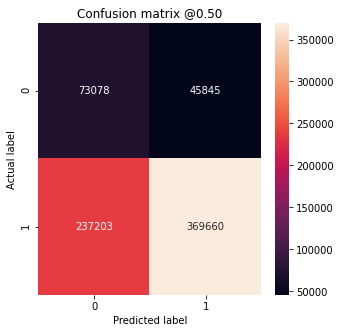

In [ ]:
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

**Show training progress**

In [ ]:
# Clear model, and create it
model = None

# Dunno if this works but as a proper programmer would say: best leave it... 
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Create the model can be outside loop but can't be bothered 
def make_model(metrics=METRICS):
      model = keras.Sequential([
          # bias = false because batchnorm
          keras.layers.Dense(64, activation='relu', input_shape=(train_features_rus.shape[-1],), use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(64, activation='relu', use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(64, activation='relu', use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(1, activation='sigmoid'),
      ])

      # Compile with new focal loss function
      model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=.001),
          loss=keras.losses.BinaryCrossentropy(),
          metrics=METRICS)
      return model
    
model = make_model()

# Fit model on train, use validation set for model fit
history = model.fit(train_features_rus,train_labels_rus, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    callbacks=[early_stopping],validation_data=(val_features_scaled, val_labels), verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping


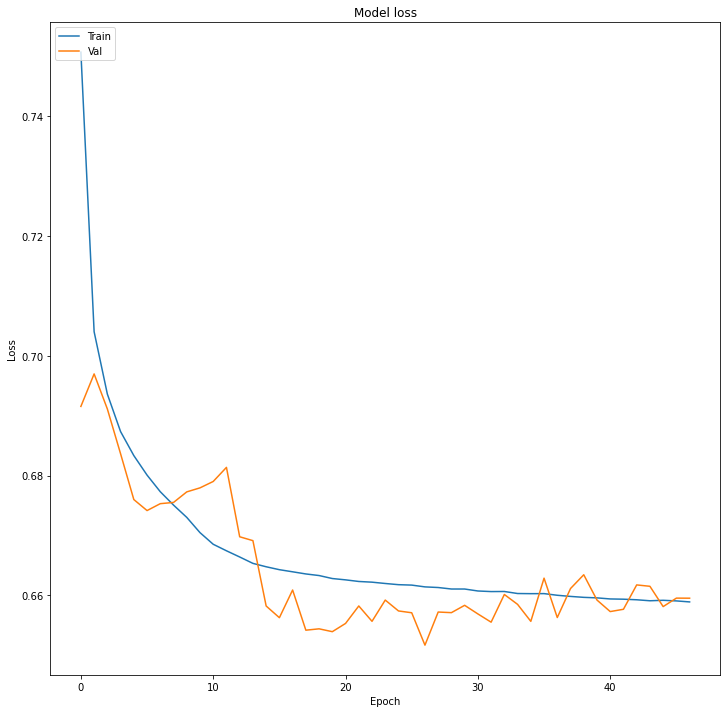

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/content/drive/My Drive/Colab Notebooks/Results/RUS_MLP_loss_plot.png')
plt.show()

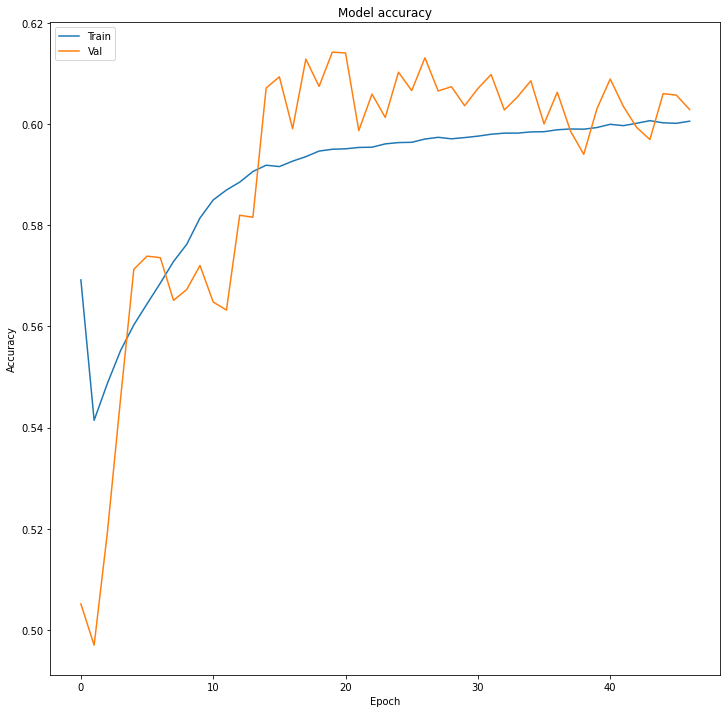

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/content/drive/My Drive/Colab Notebooks/Results/RUS_MLP_accuracy_plot.png')
plt.show()